<a href="https://colab.research.google.com/github/Shrey-Viradiya/HandsOnMachineLearning/blob/master/Representation_Learning_and_Generative_Learning_Using_Autoencoders_and_GANs.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation Learning and Generative Learning Using Autoencoders and GANs

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

## Performing PCA with an Undercomplete Linear Autoencoder

In [2]:
encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape = [3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape = [2]))
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss = 'mse', optimizer=keras.optimizers.SGD(lr=1.5))

### Generate 3D data for training

In [3]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

In [4]:
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [5]:
history = autoencoder.fit(X_train, X_train, epochs = 20)
coding = encoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 0.4510
Epoch 2/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2171
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0451
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0210
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0181
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 12/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 13/20
2/2 [==============================] - 0s 4ms/step - loss: 0.

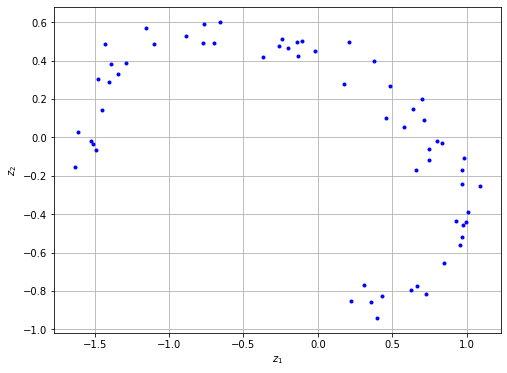

In [6]:
fig = plt.figure(figsize=(8,6))
plt.plot(coding[:,0], coding[:, 1], "b.")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.show()

## Stacked Autoencoders

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

In [10]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(30, activation = 'selu')
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])    
])

stacked_AE = keras.models.Sequential([stacked_encoder, stacked_decoder])

'''
When compiling the stacked autoencoder, we use the binary cross-entropy 
loss instead of the mean squared error. We are treating the 
reconstruction task as a multilabel binary classification problem: 
each pixel intensity represents the probability that the pixel 
should be black. Framing it this way (rather than as a regression 
problem) tends to make the model converge faster.
'''
stacked_AE.compile(loss='binary_crossentropy', optimizer= keras.optimizers.SGD(lr = 1.5),
                  metrics = [rounded_accuracy])

In [11]:
history = stacked_AE.fit(X_train, X_train, epochs= 20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3164 - val_rounded_accuracy: 0.9007
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9197
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2983 - val_rounded_accuracy: 0.9204
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9285
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

In [12]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [13]:
def show_reconstructions(AE,images=X_valid, n_images=5):
    reconstructions = AE.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 4.5))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

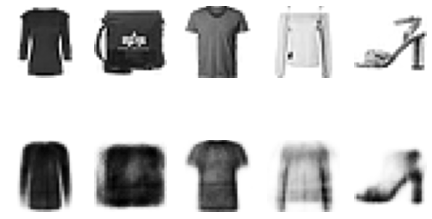

In [14]:
show_reconstructions(stacked_AE)

## Visualizing Fashion MNIST

Now that we have trained a stacked autoencoder, we can use it to reduce the dataset’s dimensionality. For visualization, this does not give great results compared to other dimensionality reduction algorithms, but one big advantage of autoencoders is that they can handle large datasets, with many instances and many features. So one strategy is to use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for visualization. Let’s use this strategy to visualize Fashion MNIST. First, we use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we use Scikit-Learn’s implementation of the t-SNE algorithm to reduce the dimensionality down to 2 for visualization

In [15]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

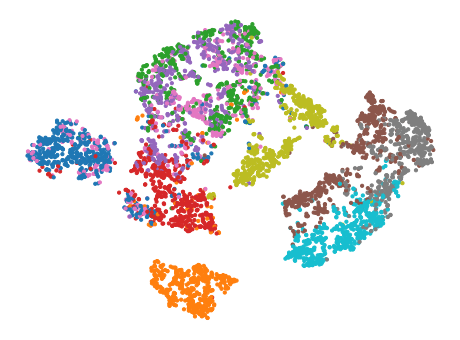

In [16]:
plt.figure(figsize = (8,6))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:,1], c=y_valid, s=10, cmap='tab10')
plt.axis(False)
plt.show()

# Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.


Specifically, if the autoencoder has a total of N layers (not counting the input layer), and $W_L$ represents the connection weights of the $L^{th}$ layer (e.g., layer 1 is the first hidden layer, layer N/2 is the coding layer, and layer N is the output layer), then the decoder layer weights can be defined simply as: $W_{N–L+1} = W_{L^T}$ (with L = 1, 2, …, N/2).

In [17]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation = None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name = 'bias',
                                      shape = [self.dense.input_shape[-1]],
                                      initializer = 'zeros')
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation = 'selu')
dense_2 = keras.layers.Dense(30, activation = 'selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

tied_AE= keras.models.Sequential([tied_encoder, tied_decoder])
tied_AE.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5), 
               metrics = [rounded_accuracy])

In [19]:
history = tied_AE.fit(X_train, X_train, epochs =10,
                     validation_data = (X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9077
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3017 - val_rounded_accuracy: 0.9087
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2889 - rounded_accuracy: 0.9301 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2874 - val_rounded_accuracy: 0.9313
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2860 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

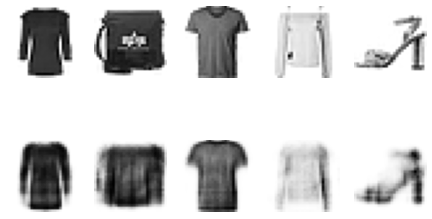

In [20]:
show_reconstructions(tied_AE)